В задаче дан снимок среза горной породы. Синие области-поры. Области белого цвета-зерна. Требуется определить найти площади и периметры пор на срезе, а также оценить диаметры Ферета и параметры анизотропии

In [1]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

from scipy.signal import argrelextrema

from skimage.color import rgb2gray
%matplotlib inline
from scipy import ndimage

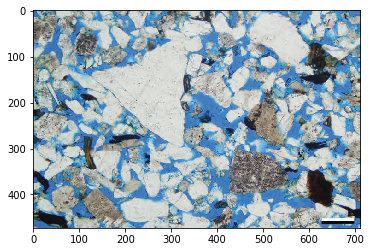

In [2]:
# Грузим изображение 

img = cv2.imread('input_data.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [6]:
img.ravel().shape

(1010328,)

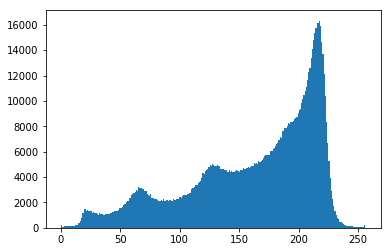

In [673]:
# Построим гистограмму интенсивности

plt.hist(img.ravel(),256,[0,256]); plt.show()

In [ ]:
# Наблюдаются четыре явные моды

In [ ]:
# Применим KDE и найдем значения мод

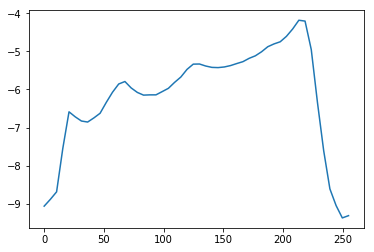

In [674]:
flattened = img.ravel().reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(flattened)
intensity = linspace(0,255)
values = kde.score_samples(intensity.reshape(-1,1))
plot(intensity, values)

In [678]:
_, maximum = argrelextrema(values, np.less)[0], argrelextrema(values, np.greater)[0]

print(intensity[maximum])

[ 20.81632653  67.65306122 130.10204082 213.36734694]


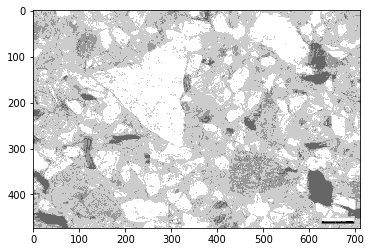

In [662]:
# Сегментируем изображение учитывая моды

gray = rgb2gray(img)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > 203./255:
        gray_r[i] = 5
    elif gray_r[i] > 120./255:
        gray_r[i] = 4
    elif gray_r[i] > 57./255:
        gray_r[i] = 3
    elif gray_r[i] > 10./255:
        gray_r[i] = 2
    elif gray_r[i] > 10./255:
        gray_r[i] = 2
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

In [663]:
# Поскольку изображение "шумит" можно пройтись по нему медианным фильтром

In [664]:
median = cv2.medianBlur(np.array(gray, dtype = 'uint8'),7)

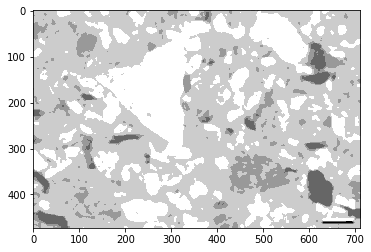

In [665]:
plt.imshow(median, cmap='gray')

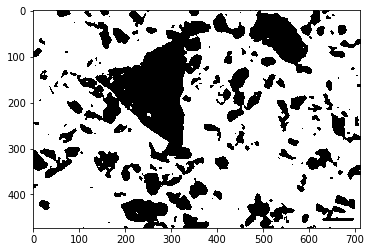

In [666]:
#Для поиска контуров зерен бинаризуем изображение методом Оцу

ret, thresh = cv2.threshold(median,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


hsv_min = np.array((2, 28, 65), np.uint8)
hsv_max = np.array((26, 238, 255), np.uint8)


#ищем контуры
_, contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


plt.imshow(thresh,cmap='gray')

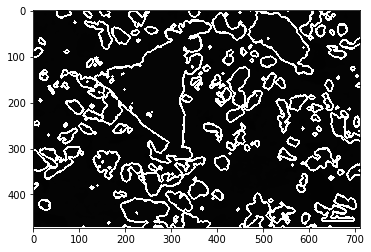

In [667]:
# Изобразим контуры

cv2.drawContours(median, contours, -1, (255,0,0), 3)
plt.imshow(median,cmap='gray')

In [ ]:
# Поместим контуры на исходное изображение

In [680]:
med = cv2.merge((median,median,median))

for i in range(med.shape[0]):
    for j in range(med.shape[1]):
        if (med[i][j] == array([255, 255, 255])).any():
            med[i][j] = array([255, 0, 0])

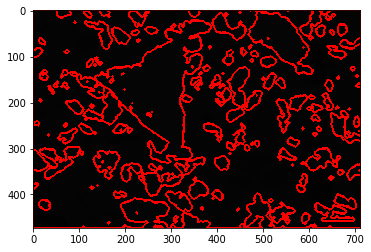

In [681]:
plt.imshow(med)

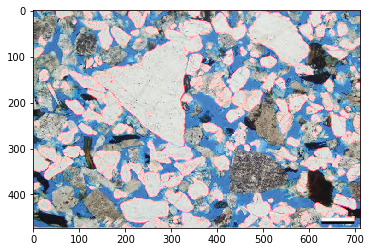

In [683]:
plt.imshow(cv2.add(img,med))

In [865]:
# сохраним изображения
cv2.imwrite('/Users/user/Data_science/MIPT/mask.png',cv2.cvtColor(med, cv2.COLOR_BGR2RGB))
cv2.imwrite('/Users/user/Data_science/MIPT/mask+image.png',cv2.cvtColor(cv2.add(img,med), cv2.COLOR_BGR2RGB))

True

In [445]:
# Добавляем зерна в dict

In [703]:
d = {str(num): grain for num, grain in enumerate(contours)}

In [690]:
# добавляем пористость (porosity)

d['porosity'] = np.sum(thresh == 255)/(thresh.shape[0]*thresh.shape[1])

In [ ]:
# Считаем параметры зерен

In [707]:
# площадь
Squares = {str(num) : cv2.contourArea(cnt) for num,cnt in enumerate(contours)}

# периметр
Perimeters = {str(num) : cv2.arcLength(cnt, True) for num,cnt in enumerate(contours)}

In [ ]:
# Для оценки максимального и среднего диаметр Ферета,
# а также для расчета анизотропии,
# построим вокруг каждого зерна ограничивающий прямоугольник минимальной площади
# его длина - оценка максимального диаметра Ферета
# его ширина - оценка минимального диаметра Ферета
# угол поворота - оценка направление максимального диаметра Ферета

In [788]:
# 2й элемент 

Feret_max = {str(num) : max(cv2.minAreaRect(contours[num])[1]) for num,cnt in enumerate(contours)}
Feret_min = {str(num) : min(cv2.minAreaRect(contours[num])[1]) for num,cnt in enumerate(contours)}
Rotation_angle = {str(num) : cv2.minAreaRect(contours[num])[2] for num,cnt in enumerate(contours)}

In [789]:
for num,angle in Rotation_angle.items():
    if angle<=0:
        Rotation_angle[num]= (-1)*Rotation_angle[num] + 180

(array([ 3.,  0.,  0.,  0.,  0., 39., 12., 86., 21., 14.]),
 array([ 90., 108., 126., 144., 162., 180., 198., 216., 234., 252., 270.]),
 <a list of 10 Patch objects>)

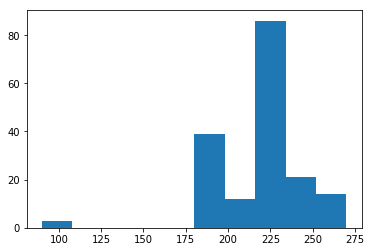

In [790]:
# Визуализируем углы анизотропии

plt.hist(np.array(list(Rotation_angle.values())))

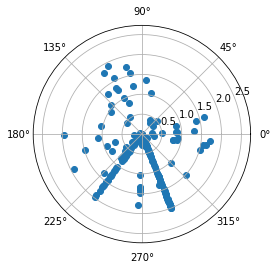

In [795]:
N = len(Rotation_angle)
r = 2 * np.random.rand(N)
theta = list(Rotation_angle.values())

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r)

In [848]:
# Формируем выходные данные 

df = pd.DataFrame({'Squares':list(Squares.values()),
              'Perimeters':list(Perimeters.values()),
             'Feret_max':list(Feret_max.values()),
             'Feret_min':list(Feret_min.values()),
                  'contours':list(d.values())})

In [841]:
# уберем слишком маленькие зерна ( <5px)

In [849]:
df = df[(df['Squares']>5)]

In [850]:
df = df[(df['Squares']>5)&(df['Squares'] < 300000)].reset_index(drop = True)

In [844]:
# переведем данные в микроны

In [852]:
df['Squares'] = df['Squares'] *4.85
df['Perimeters'] = df['Perimeters'] *4.85
df['Feret_max'] = df['Feret_max'] *4.85
df['Feret_min'] = df['Feret_min'] *4.85

In [860]:
# сохраняем в json
df.to_json('output.json',orient='index')

In [862]:
# сохраняем в xlsx
df.to_excel('output.xlsx')